In [85]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
from config import settings
from src.data import datamodule as dm
from pathlib import Path
from src.model.transformation import (FromBuffer , 
                                      CutPSD, LogTransform , NormLayer , SqueezeLayer,
                                      UnsqueezeLayer)


import matplotlib.pyplot as plt
from torch import nn 
from src.data.utils import print_database_overview, load_all_from_db
from src.model.prepared_queries import view_melt_welch_only


In [87]:
db_path = Path(settings.path.processed, 'norther2.db')
assert db_path.exists(), f"Database not found at {db_path}"
print_database_overview(db_path)
meta_data = load_all_from_db(db_path, 'metadata')
frequency_axis = FromBuffer()(meta_data.loc[0,'frequency_axis'])

SQLite Database Overview
Table: processed_data - id, timestamp, turbine_name, Welch_X, Welch_Y, Welch_Z, RMS_X, RMS_Y, RMS_Z, RollingAverage_X, RollingAverage_Y, RollingAverage_Z, Range_X, Range_Y, Range_Z, Mean_X, Mean_Y, Mean_Z
Table: sqlite_sequence - name, seq
Table: metadata - frequency_axis, sample_rate, window_size, processing_method
Table: scada - timestamp, mean_windspeed, min_windspeed, max_windspeed, std_windspeed, mean_yaw, min_yaw, max_yaw, std_yaw, mean_power, min_power, max_power, std_power, mean_pitch, min_pitch, max_pitch, std_pitch, mean_rpm, min_rpm, max_rpm, std_rpm, mean_winddirection, min_winddirection, max_winddirection, std_winddirection, mean_NAC_ACC_Z, min_NAC_ACC_Z, max_NAC_ACC_Z, rms_NAC_ACC_Z, rms1p_NAC_ACC_Z, mean_NAC_ACC_FA, min_NAC_ACC_FA, max_NAC_ACC_FA, rms_NAC_ACC_FA, rms1p_NAC_ACC_FA, mean_NAC_ACC_SS, min_NAC_ACC_SS, max_NAC_ACC_SS, rms_NAC_ACC_SS, rms1p_NAC_ACC_SS, mean_ti, pred_Mtn_legacy, relative_wind_dir, pred_Mtn_dnn, Mean_muY, CoV, std_NAC_ACC

/tmp/ipykernel_3047442/1222168015.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_C01.query('timestamp > "2023-06-01" and timestamp < "2023-07-10"', inplace=True)


<Axes: xlabel='timestamp'>

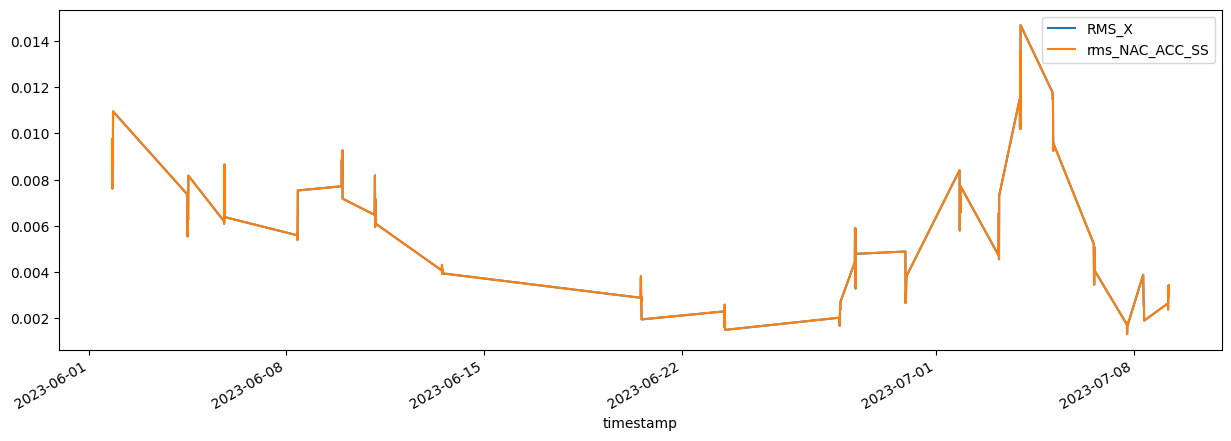

In [88]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# SQL query to merge the required columns from processed_data and scada
query = """
SELECT 
    p.timestamp, 
    p.turbine_name, 
    p.RMS_X, 
    s.rms_NAC_ACC_SS
FROM 
    processed_data p
LEFT JOIN 
    scada s
ON 
    p.timestamp = s.timestamp 
    AND p.turbine_name = s.turbine_name
WHERE 
    p.RMS_X IS NOT NULL 
    AND s.rms_NAC_ACC_SS IS NOT NULL;
"""

# Execute the query and load the result into a pandas DataFrame
merged_data = pd.read_sql_query(query, conn)
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp']).dt.tz_localize(None)
merged_data_C01 = merged_data[merged_data['turbine_name'] == 'NRTC01']
merged_data_C01.query('timestamp > "2023-06-01" and timestamp < "2023-07-10"', inplace=True)
merged_data_C01.plot(x='timestamp', y=['RMS_X', 'rms_NAC_ACC_SS'], figsize=(15, 5))


In [89]:

columns = ["Welch"]
transform_func = [nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 2)),LogTransform())]
key_query  = f"""SELECT unique_id FROM melted_view 
WHERE timestamp BETWEEN '{settings.norther.training_start}' AND '{settings.norther.training_end}'


"""


data_loader = dm.PSDDataModule(
    db_path=db_path,
    view_query=view_melt_welch_only, 
    view_table_name='melted_view',          # the view_table_name
    key_query=key_query,
    key_name='unique_id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=128,
    cached=True,
)


In [90]:
import pytorch_lightning as pl
from src.model.backcone import AutoEncoderConv, AutoEncoder
from torch import optim
class TrainingAutoEncoderConv(pl.LightningModule):
    def __init__(self, lr: float):
        super().__init__()
        self.model = AutoEncoder(hidden_dim=[264,64,32,16],activation_fn='swish')
        self.lr = lr
        self.loss = nn.L1Loss()
        self.save_hyperparameters(ignore=['model'])
        
    def forward(self, x):
        return self.model(x)
    
    def forward_embedding(self, x):
        return self.model.encoder(x)

    def _common_step(self, batch, batch_idx, stage):
        x = batch[0]
        x_hat = self.model(x)
        loss = self.loss(x, x_hat)
        self.log(f'{stage}_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, 'val')
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [91]:
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar

mlflow_logger = MLFlowLogger(experiment_name="CAE-allturbine",
                            save_dir=settings.path.mlflow[1:])

checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, filename='AE-{epoch:02d}-{val_loss:.2f}')
trainer = pl.Trainer(max_epochs=20, logger=mlflow_logger, callbacks=[checkpoint_callback, RichProgressBar()])
model_ae = TrainingAutoEncoderConv(lr=1e-3)

#trainer.fit(model_ae, data_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [92]:
best_model_path = Path(checkpoint_callback.best_model_path)
model_ae = TrainingAutoEncoderConv.load_from_checkpoint(best_model_path)


IsADirectoryError: [Errno 21] Is a directory: '/home/owilab/Documents/YacineB/Code/damage_prediction_AE'

In [93]:
data = next(iter(data_loader.train_dataloader()))[0]
data = data.to(model_ae.device)
data_rec = model_ae(data)
fig,ax  = plt.subplots(2,2)
for i,(psd_in, psd_out) in enumerate(zip(data[0:4], data_rec[0:4])):
    ax[i//2, i%2].plot(frequency_axis[0:263], psd_in.cpu().numpy())
    ax[i//2, i%2].plot(frequency_axis[0:263], psd_out.cpu().detach().numpy())
plt.show()


AttributeError: 'PSDDataModule' object has no attribute 'train_dataset'

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
from src.model.transformation import ToTensor
from src.model.prepared_queries import create_merge_scada
columns = ["Welch","DEM"]
fleet_leaders = list(settings.norther.fleet_leader)
transform_func = [nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 2)),LogTransform()),ToTensor()]
assert len(columns) == len(transform_func)
key_query  = f"""SELECT id FROM merged 
WHERE timestamp BETWEEN '{settings.norther.training_start}' AND '{settings.norther.training_end}'
AND Turbine_name =='NRTC01'
"""


data_loader_dem = dm.PSDDataModule(
    db_path=db_path,
    view_query=create_merge_scada, 
    view_table_name='merged',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=32,
    cached=True,
)


In [95]:
import torch
from torch import nn, optim
import pytorch_lightning as pl
from src.model.backcone import SimpleMLP

class AutoEncoderRegressor(pl.LightningModule):
    def __init__(self, encoder: nn.Module, regressor: nn.Module, lr: float = 1e-3):
        super(AutoEncoderRegressor, self).__init__()
        self.encoder = encoder
        self.regressor = regressor
        self.lr = lr
        self.loss_fn = nn.MSELoss()  # Assuming DEM is a continuous variable


        
        # Freeze the encoder
        for param in self.encoder.parameters():
            param.requires_grad = True
        for param in self.regressor.parameters():
            param.requires_grad = True
        self.model = nn.Sequential(encoder, regressor)
        self.save_hyperparameters(ignore=['encoder', 'regressor'])


    def forward(self, x):
        encoded = self.encoder(x)
        pred = self.regressor(encoded)
        return pred
    

    def training_step(self, batch, batch_idx):
        x, y = batch  # x: Welch, y: DEM
        y_pred = self(x)
        y = y.unsqueeze(-1)
    
        loss = self.loss_fn(y_pred, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        y = y.unsqueeze(-1)
        loss = self.loss_fn(y_pred, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        return optimizer


In [96]:
data_loader_dem.setup()

In [97]:
import numpy as np
min_y , max_y = np.inf, -np.inf
for batch in data_loader_dem.train_dataloader():
    x,y = batch
    min_y = min(min_y, y.min())
    max_y = max(max_y, y.max())

In [98]:
min_y

tensor(150094.9062)

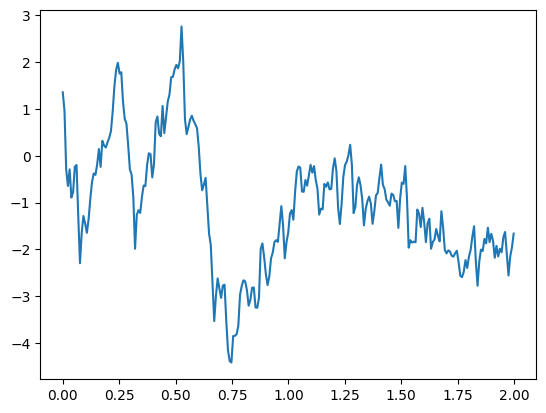

In [99]:
plt.plot(frequency_axis[0:263], x[0].cpu().numpy())

In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
from src.model.backcone import SimpleMLP
regressor = SimpleMLP(input_dim=16,hidden_dim=[32,32,16,8,1],min_val=min_y, max_val=max_y)
encoder = model_ae.model.encoder
encoder.eval()
model_all = AutoEncoderRegressor(encoder=encoder, regressor=regressor, lr=5e-3)
mlflow_logger = MLFlowLogger(
    experiment_name="AE-allturbine-Regressor-c01-turbine",
    save_dir=settings.path.mlflow[1:]
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', 
    save_top_k=1, 
    filename='AE-Regressor-{epoch:02d}-{val_loss:.2f}'
)
trainer = pl.Trainer(max_epochs=200, logger=mlflow_logger, callbacks=[checkpoint_callback])

trainer.fit(model_all, data_loader_dem)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | encoder   | Sequential | 90.0 K | eval 
1 | regressor | SimpleMLP  | 2.5 K  | train
2 | loss_fn   | MSELoss    | 0      | train
3 | model     | Sequential | 92.5 K | train
-------------------------------------------------
92.5 K    Trainable params
0         Non-trainable params
92.5 K    Total params
0.370     Total estimated model params size (MB)
21        Modules in train mode
11        Modules in eval mode


Already set


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [102]:
from src.model.transformation import ToTensor
from src.model.prepared_queries import create_merge_scada
columns = ["timestamp","turbine_name","Welch","DEM"]
fleet_leaders = list(settings.norther.fleet_leader)
transform_func = [nn.Identity(),nn.Identity(),nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 2)),LogTransform()),ToTensor()]
assert len(columns) == len(transform_func)
key_query  = f"""SELECT id FROM merged WHERE turbine_name in {tuple(fleet_leaders)} """


data_loader_dem_all = dm.PSDDataModule(
    db_path=db_path,
    view_query=create_merge_scada, 
    view_table_name='merged',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=5000,
    cached=False,
)

In [103]:
data_loader_dem_all.setup()

In [104]:
import pandas as pd
dfs = []

for b in data_loader_dem_all.all_dataloader():
    timestamps, turbine_names, welch, dem = b
    dem_pred = model_all(welch) 
    emb = model_all.encoder(welch)
    df_temp = pd.DataFrame({
        'timestamp': np.array(timestamps),
        'turbine_name': np.array(turbine_names),
        'dem': np.array(dem),
        'dem_pred': dem_pred.squeeze().detach().numpy(),
        'emb': [row for row in emb.detach().cpu().numpy()]
    })
    dfs.append(df_temp)

/tmp/ipykernel_3047442/718956641.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  'dem': np.array(dem),


In [105]:
pd.concat(dfs)

,timestamp,turbine_name,dem,dem_pred,emb
0,2023-01-28 11:00:00+00:00,NRTC01,4.742389e+05,4.695535e+05,"[-0.050097603, -0.13200001, 4.2107124, -0.0494..."
1,2023-01-28 11:10:00+00:00,NRTC01,6.030971e+05,4.698565e+05,"[-0.060584415, -0.14910048, 3.9991174, -0.0443..."
2,2023-01-28 11:20:00+00:00,NRTC01,5.024614e+05,4.685552e+05,"[-0.12517664, -0.22549313, 3.3948388, 0.011099..."
3,2023-01-28 11:30:00+00:00,NRTC01,4.843187e+05,4.714360e+05,"[-0.14512789, -0.24793994, 2.8611922, -0.03460..."
4,2023-01-28 11:40:00+00:00,NRTC01,1.085948e+06,4.903003e+05,"[-0.27846247, -0.16527674, 0.34092945, -0.2381..."
...,...,...,...,...,...
3851,2023-04-21 19:10:00+00:00,NRTJ03,1.967300e+06,1.693917e+06,"[-0.27192298, 1.298401, -0.016845247, -0.22549..."
3852,2023-04-21 19:20:00+00:00,NRTJ03,2.194109e+06,1.262496e+06,"[-0.22866835, 0.6675591, -0.08052968, -0.27786..."
3853,2023-04-21 19:30:00+00:00,NRTJ03,1.606459e+06,8.252106e+05,"[0.017496655, 0.29843265, -0.27805826, -0.0999..."
3854,2023-04-21 19:40:00+00:00,NRTJ03,2.012463e+06,1.267203e+06,"[-0.20858371, 0.75182736, -0.08558939, -0.2783..."


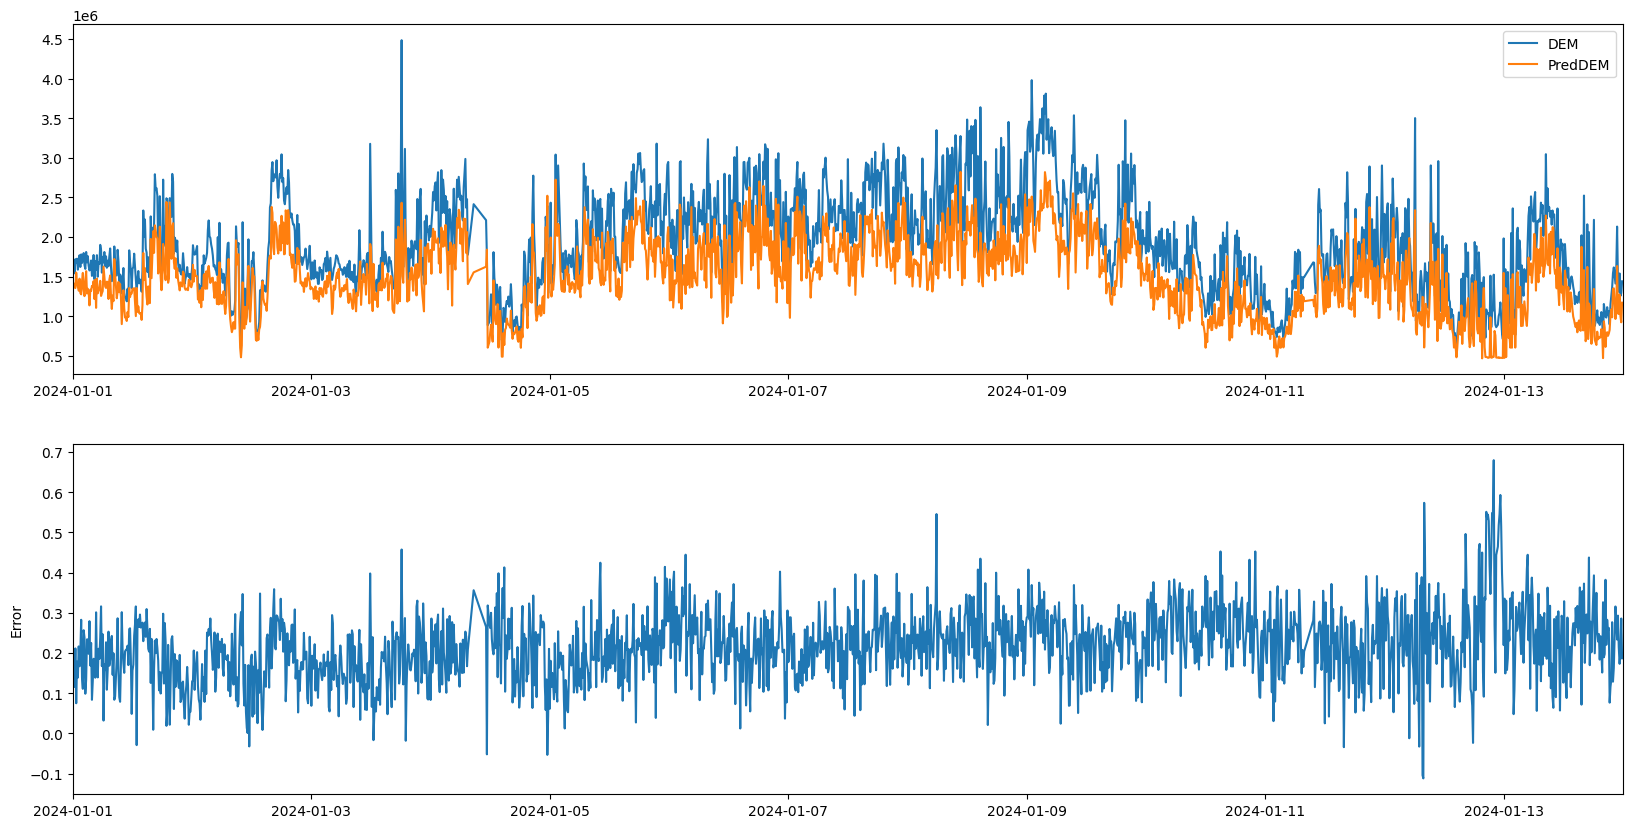

In [106]:
data = pd.concat(dfs).query("turbine_name == 'NRTC01' and '2024-01-01' <= timestamp <= '2024-01-14'")
data['timestamp'] = pd.to_datetime(data['timestamp'])
fig , ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(data['timestamp'], data['dem'], label='DEM')
ax[0].plot(data['timestamp'], data['dem_pred'], label='PredDEM')
ax[0].set_xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2024-01-14'))
ax[0].legend()
err  = (data['dem'] - data['dem_pred']) / data['dem']
ax[1].plot(data['timestamp'], err, label='Error')
ax[1].set_xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2024-01-14'))
ax[1].set_ylabel('Error')
plt.show()


In [ ]:
emb

tensor([[3.4890, 0.0000, 2.6337,  ..., 3.3269, 2.7076, 2.3909],
        [4.0283, 0.0000, 2.9755,  ..., 3.4521, 2.8745, 2.3924],
        [2.8965, 0.0000, 2.2146,  ..., 2.6367, 2.2432, 2.4005],
        ...,
        [0.0000, 0.9593, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0402, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.1225, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])